#DATA SIZE

In [ ]:
!pip install split-folders

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import splitfolders

# Augment images
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data/'
img_data = {}

for folder in os.listdir(DATA_DIR):
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

Mounted at /content/drive


Prikazuje se broj slika po klasi prije augmentacije, pri čemu se jasno uočava neravnoteža — naročito manji broj slika za bazalt i granit, što opravdava potrebu za augmentacijom.

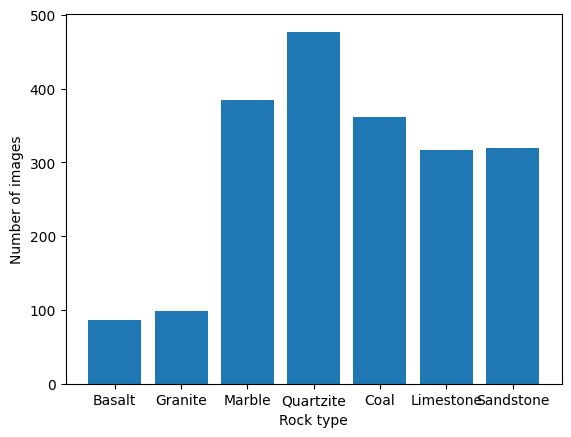

In [ ]:
num_img = [len(v) for k,v in img_data.items()]
plt.bar(img_data.keys(), num_img)
plt.ylabel('Number of images')
plt.xlabel('Rock type')
plt.show()

Razlika u zastupljenosti ostaje izražena i pri grupisanju stijena u šire klase, što dodatno potvrđuje potrebu za balansiranjem podataka.

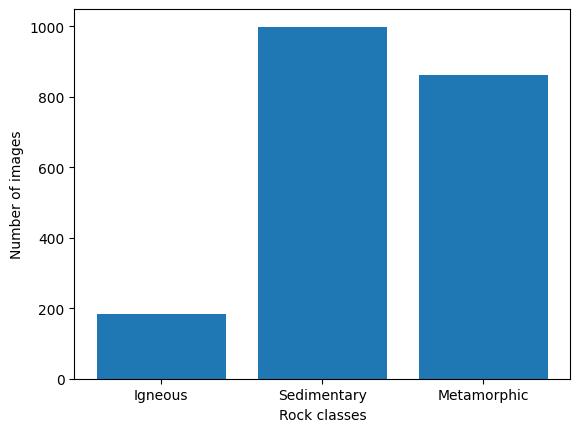

In [ ]:
rock_classes = {
    "Igneous": len(img_data['Basalt']) + len(img_data['Granite']),
    "Sedimentary": len(img_data['Limestone']) + len(img_data['Sandstone']) + len(img_data['Coal']),
    "Metamorphic": len(img_data['Quartzite']) + len(img_data['Marble'])
}

plt.bar(rock_classes.keys(), rock_classes.values())
plt.ylabel('Number of images')
plt.xlabel('Rock classes')
plt.show()

Kako bi se obezbijedila bolja generalizacija modela i spriječi overfitting, podaci se dijele na trenirajući, validacioni i testni skup koristeći biblioteku splitfolders, koja omogućava kontrolisanu i reproducibilnu podjelu podataka u unaprijed definisanim omjerima.:

In [ ]:
DATA_DIR = "/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/data"
OUTPUT_DIR = "/content/drive/MyDrive/PROJEKAT_VI/rock_clasification/output/"

import splitfolders

splitfolders.fixed(
    DATA_DIR,
    output=OUTPUT_DIR,
    seed=1337,
    fixed=(20, 20)
)


Copying files: 2044 files [00:52, 38.97 files/s]


Za potrebe balansiranja skupa podataka, definisan je niz augmentacijskih transformacija koje simuliraju varijacije u orijentaciji, osvjetljenju i teksturi slika. Nakon toga, trenirajući skup se analizira kako bi se utvrdila veličina najveće klase, a sve klase koje sadrže manji broj uzoraka se augmentiraju dok se ne izjednače sa najvećom klasom. Time se osigurava uravnotežen skup podataka, što pozitivno utiče na stabilnost i performanse modela pri treniranju.

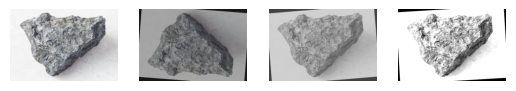

In [ ]:
image_transforms = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomGrayscale(0.5),
        transforms.RandomAdjustSharpness(0.5),
        transforms.ColorJitter(0.4, 0.4, 0.4),
        transforms.GaussianBlur(3),
        transforms.ToTensor()
    ]
)

img = Image.open(img_data['Basalt'][0])
fig, axarr = plt.subplots(1,4)
aug_test = [image_transforms(img).permute(1, 2, 0) for i in range(3)]
for ax, im in zip(axarr, [img]+aug_test):
    ax.imshow(im)
    ax.axis('off')
plt.show()

In [ ]:
train_data = {}

for folder in os.listdir(OUTPUT_DIR+'train/'):
    img_path = OUTPUT_DIR+'train/' + folder + '/'
    train_data[folder] = [img_path + img for img in os.listdir(img_path)]

max_num_img = max([len(v) for k,v in train_data.items()])
print(f"Number of images in largest class: {max_num_img}")

Number of images in largest class: 437


In [ ]:
for folder, path_list in train_data.items():
    if len(path_list) < max_num_img:
        sets = (max_num_img-len(path_list)) // len(path_list)
        mod = (max_num_img-len(path_list)) % len(path_list)
        for i, path in enumerate(path_list):
            img = Image.open(path)
            img = img.convert('RGB')
            sets_iter = sets + 1 if i < mod else sets
            for k in range(sets_iter):
                save_image(image_transforms(img), f'{OUTPUT_DIR}/train/{folder}/augmented_{i}_{k}.jpg')

Nakon primjene augmentacije, vizualizovana je konačna distribucija trening slika po klasama. Graf potvrđuje da su sve klase sada balansirane, čime se osigurava ravnomjerna zastupljenost tokom treniranja modela.

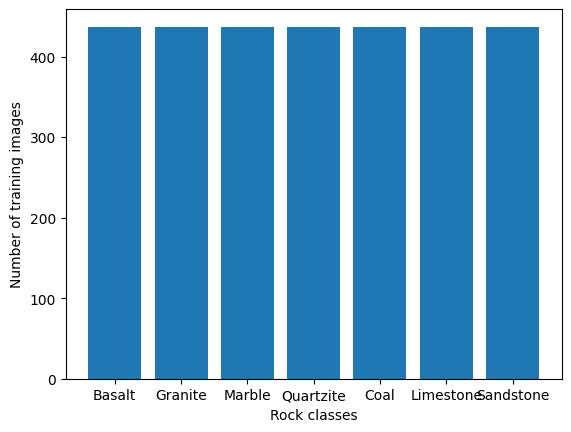

In [ ]:
aug_data = {}

for folder in os.listdir(OUTPUT_DIR + 'train/'):
    img_path = OUTPUT_DIR + 'train/' + folder + '/'
    aug_data[folder] = len(os.listdir(img_path))

plt.bar(aug_data.keys(), aug_data.values())
plt.ylabel('Number of training images')
plt.xlabel('Rock classes')
plt.show()